# CNN
Training auf Hybrid_b17_test 80%  
Validierung auf Hybrid_b17_test 10%   
Test auf Hybrid_b17_test 10% 

In [1]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

2024-11-23 21:56:37.556476: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 21:56:37.566035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 21:56:37.577816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 21:56:37.581770: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 21:56:37.590319: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='31_cnn.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
ids17_prep_1 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_1/ids17.parquet'
ids18_prep_1 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_1/ids18.parquet'
hybrid_train_prep_1 =  '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_train.parquet'
hybrid_test_prep_1 = '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_test.parquet'

### Laden des Datensatzes

In [3]:
# Datensatz einlesen für Training 80%, Validierung 10% und Test 10%
df = pd.read_parquet(hybrid_train_prep_1)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.shape)
print(df.columns)

2024-11-23 21:56:39 - INFO - Class distribution
Label
DoS Hulk                        158468
BENIGN                          158257
DDoS-LOIC-HTTP                   95144
Infiltration - NMAP Portscan     71767
DoS GoldenEye                     7567
DoS Slowloris                     3859
SSH-BruteForce                    2961
Botnet Ares                        736
Name: count, dtype: int64


(498759, 51)
Index(['Total TCP Flow Time', 'Fwd IAT Total', 'Fwd Header Length', 'Idle Std',
       'Bwd Header Length', 'Dst Port', 'ECE Flag Count', 'Fwd IAT Max',
       'Fwd Packet Length Max', 'Fwd PSH Flags', 'Fwd Bulk Rate Avg',
       'Protocol', 'Bwd Packet Length Min', 'Bwd Init Win Bytes',
       'Flow Bytes/s', 'Fwd IAT Mean', 'FWD Init Win Bytes',
       'Fwd Packet Length Min', 'Total Length of Fwd Packet', 'Bwd IAT Std',
       'Bwd IAT Min', 'Bwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg',
       'Bwd Packet Length Std', 'Bwd URG Flags', 'Flow IAT Mean',
       'Fwd IAT Min', 'Subflow Bwd Packets', 'Fwd Seg Size Min',
       'Fwd RST Flags', 'Bwd PSH Flags', 'Flow IAT Max', 'FIN Flag Count',
       'SYN Flag Count', 'Bwd IAT Total', 'Bwd Segment Size Avg',
       'Down/Up Ratio', 'Total Fwd Packet', 'Packet Length Variance',
       'Fwd URG Flags', 'Flow IAT Min', 'Active Min', 'Bwd IAT Mean',
       'Bwd Packets/s', 'Bwd RST Flags', 'RST Flag Count', 'Active Std',
       'Su

### Trennen von Features und Labels

In [4]:
X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (498759, 50)
Form von y: (498759,)


### Label Encoding für y

In [5]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce']
Kodierte Labels: [0 1 2 3 4 5 6 7]


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [6]:
# Aufteilen in Trainings- und temporäre Datensätze
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

# Aufteilen in Validierungs- und Testdaten
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Form von X_train:", X_train.shape)
print("Form von X_val:", X_val.shape)
print("Form von X_test:", X_test.shape)


Form von X_train: (399007, 50)
Form von X_val: (49876, 50)
Form von X_test: (49876, 50)


### Skallierung von X

In [7]:
# Skalieren der Daten
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit auf Trainingsdaten
X_val_scaled = scaler.transform(X_val)         # Transform auf Val.-Daten
X_test_scaled = scaler.transform(X_test)       # Transform auf Testdaten

### Umformen der Daten für das CNN

In [8]:
# Anzahl der Features
num_features = X_train_scaled.shape[1]

# Umformen zu (Anzahl_Beispiele, num_features, 1)
X_train_scaled = X_train_scaled.reshape(-1, num_features, 1)
X_val_scaled = X_val_scaled.reshape(-1, num_features, 1)
X_test_scaled = X_test_scaled.reshape(-1, num_features, 1)

print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

(399007, 50, 1)
(49876, 50, 1)
(49876, 50, 1)


### Überprüfen der Klassenverteilung

In [9]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_train, "Trainingsdatensatz")
print_class_distribution(y_val, "Validierungsdatensatz")
print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Trainingsdatensatz:
  Klasse 0: 126605 Beispiele (31.73%)
  Klasse 1: 589 Beispiele (0.15%)
  Klasse 2: 76115 Beispiele (19.08%)
  Klasse 3: 6054 Beispiele (1.52%)
  Klasse 4: 126774 Beispiele (31.77%)
  Klasse 5: 3087 Beispiele (0.77%)
  Klasse 6: 57414 Beispiele (14.39%)
  Klasse 7: 2369 Beispiele (0.59%)

Klassenverteilung in Validierungsdatensatz:
  Klasse 0: 15826 Beispiele (31.73%)
  Klasse 1: 73 Beispiele (0.15%)
  Klasse 2: 9515 Beispiele (19.08%)
  Klasse 3: 756 Beispiele (1.52%)
  Klasse 4: 15847 Beispiele (31.77%)
  Klasse 5: 386 Beispiele (0.77%)
  Klasse 6: 7177 Beispiele (14.39%)
  Klasse 7: 296 Beispiele (0.59%)

Klassenverteilung in Testdatensatz:
  Klasse 0: 15826 Beispiele (31.73%)
  Klasse 1: 74 Beispiele (0.15%)
  Klasse 2: 9514 Beispiele (19.08%)
  Klasse 3: 757 Beispiele (1.52%)
  Klasse 4: 15847 Beispiele (31.77%)
  Klasse 5: 386 Beispiele (0.77%)
  Klasse 6: 7176 Beispiele (14.39%)
  Klasse 7: 296 Beispiele (0.59%)



 ### Modell erstellen und trainieren

In [10]:
num_features = len(X_train.columns)  # Anzahl der Merkmale
num_classes = len(label_encoder.classes_)  # Anzahl der Klassen

model = Sequential([
    InputLayer(shape=(num_features, 1), name = 'Input-Layer'),  # Eingabeschicht
    Conv1D(120, kernel_size=2, activation='relu', padding="same", name='Conv1D-1'),
    Conv1D(60, kernel_size=3, activation='relu', padding="same", name='Conv1D-2'),
    Conv1D(30, kernel_size=4, activation='relu', padding="same", name='Conv1D-3'),
    Flatten(name='Flatten'),
    Dense(num_classes, activation='softmax', name = 'Output-Layer')  # Ausgabeschicht
])

# Kompiliere das Modell
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Passend für Integer-kodierte Labels
              metrics=['sparse_categorical_accuracy'])  # Genauigkeit für integer Labels

# Modellübersicht
model.summary()



I0000 00:00:1732395399.627956 1346761 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732395399.649634 1346761 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732395399.649676 1346761 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732395399.651822 1346761 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732395399.651860 1346761 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1D-1 (Conv1D)               │ (None, 50, 120)        │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D-2 (Conv1D)               │ (None, 50, 60)         │        21,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D-3 (Conv1D)               │ (None, 50, 30)         │         7,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 8)              │        12,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,258 (161.16 KB)

 Trainable params: 41,258 (161.16 KB)

 Non-trainable params: 0 (0.00 B)

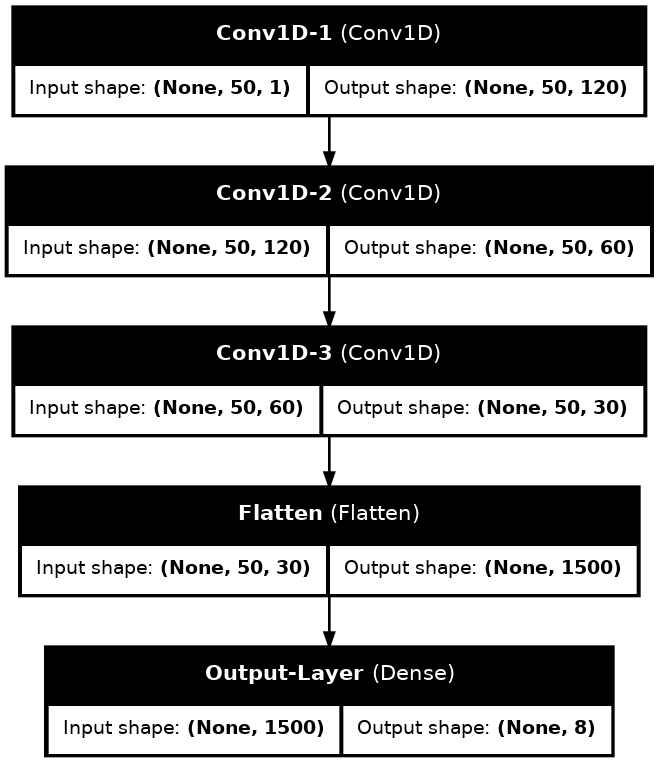

In [11]:
# Modell visualisieren und als PNG speichern
plot_model(
    model, 
    to_file='model_structure.png',  # Speicherort der Grafik
    show_shapes=True,  # Zeigt die Form der Tensoren an
    show_layer_names=True,  # Zeigt die Namen der Schichten an
    dpi=96  # Auflösung
)


### Trainieren des Modells

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20


I0000 00:00:1732395404.937343 1346935 service.cc:146] XLA service 0x7f0f88016e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732395404.937381 1346935 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-23 21:56:44.951166: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-23 21:56:45.020412: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  129/12469 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.6919 - sparse_categorical_accuracy: 0.8140

I0000 00:00:1732395406.304950 1346935 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12469/12469 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 0.0382 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.0049 - val_sparse_categorical_accuracy: 0.9988
Epoch 2/20
12469/12469 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 0.0033 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0020 - val_sparse_categorical_accuracy: 0.9995
Epoch 3/20
12469/12469 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.0025 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.0023 - val_sparse_categorical_accuracy: 0.9994
Epoch 4/20
12469/12469 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 0.0019 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.0015 - val_sparse_categorical_accuracy: 0.9995
Epoch 5/20
12469/12469 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.0015 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.0018 - val_sparse_categorical_accuracy: 0.9994
Epoch 6/20
12469/12469 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.0014 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.0014 - val_sparse_categorical_ac

### Trainingsverlauf plotten

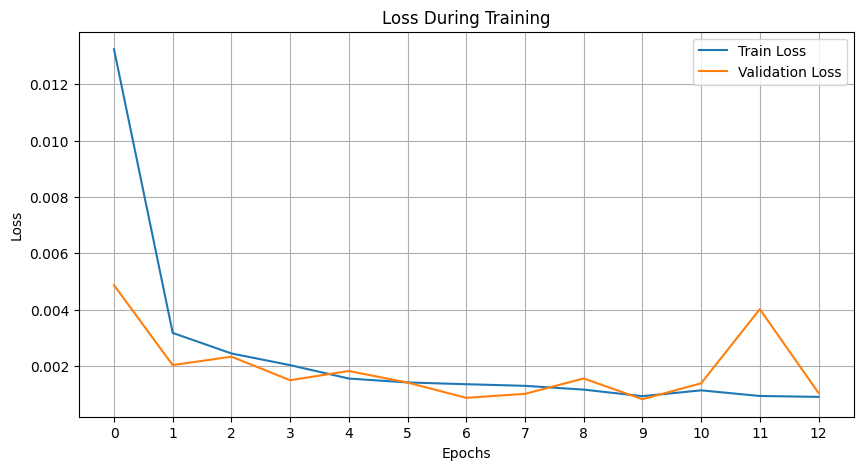

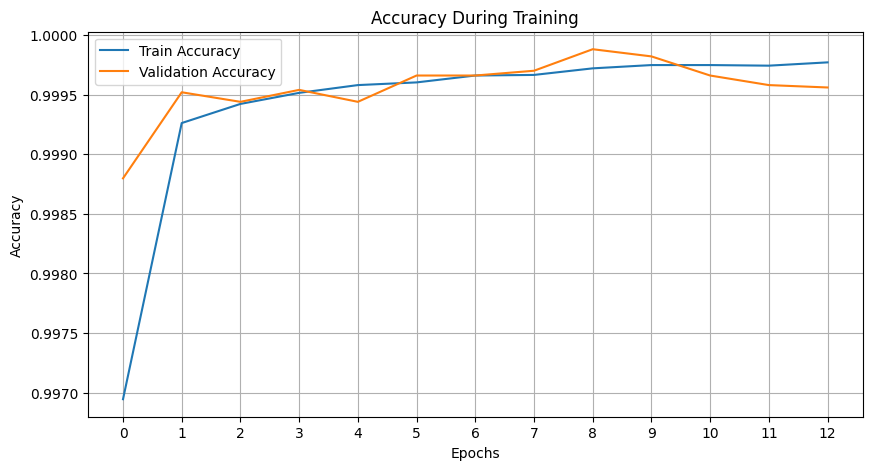

In [13]:
# Trainingsverlauf auslesen
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

# Verlust (Loss) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_loss)))
plt.show()

# Genauigkeit (Accuracy) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_accuracy)))
plt.show()

### Evaluierung des Modells auf dem Testdatensatz

#### Klassifikationsbericht und Konfusionsmatrix

In [14]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)

1559/1559 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step
                              precision    recall  f1-score   support

                      BENIGN       1.00      1.00      1.00     15826
                 Botnet Ares       1.00      1.00      1.00        74
              DDoS-LOIC-HTTP       1.00      1.00      1.00      9514
               DoS GoldenEye       1.00      1.00      1.00       757
                    DoS Hulk       1.00      1.00      1.00     15847
               DoS Slowloris       1.00      1.00      1.00       386
Infiltration - NMAP Portscan       1.00      1.00      1.00      7176
              SSH-BruteForce       1.00      1.00      1.00       296

                    accuracy                           1.00     49876
                   macro avg       1.00      1.00      1.00     49876
                weighted avg       1.00      1.00      1.00     49876



Visualisierung der Konfusionsmatrix

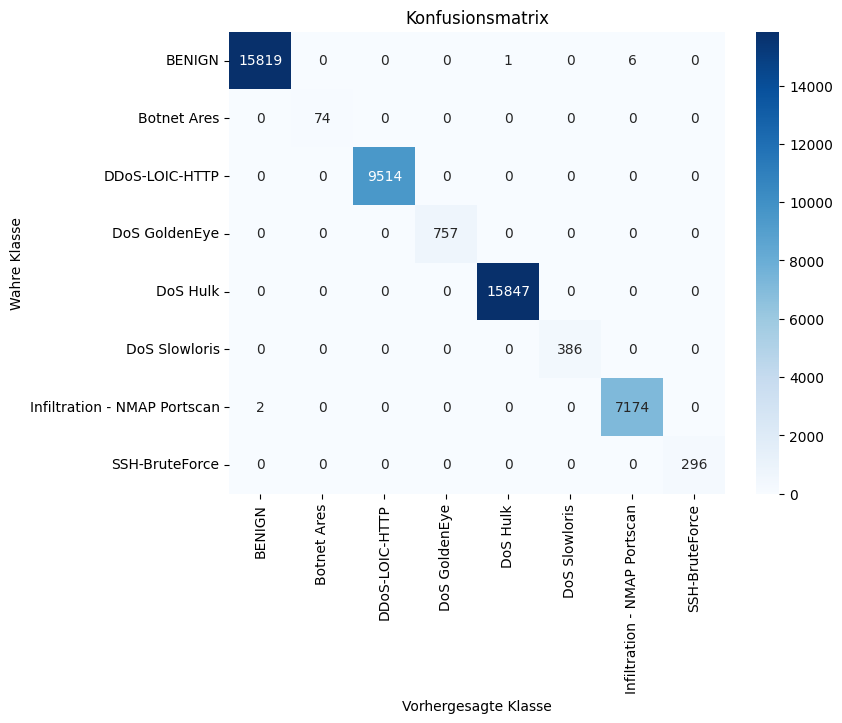

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()


### Speichern von Modell, Encoder und Scaler

In [16]:
# Speichern des Modells
model.save('model.keras')

# Speichern des Label Encoders und Scalers
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']